## package

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BI/data/heart.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

## preproccess

In [ ]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [ ]:
df['Ca'] = df['Ca'].fillna(0)
df['Thal'] = df['Thal'].fillna('normal')

類別 >> 數值

In [ ]:
df['AHD'].replace({'Yes':1,'No':0},inplace=True)

dummy

In [ ]:
Thal = pd.get_dummies(df['Thal'])
ChestPain = pd.get_dummies(df['ChestPain'])

PCA

In [ ]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(Thal)
Thal_pca = pd.DataFrame(data = principalComponents,columns = ['Thal_pca'])

In [ ]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(ChestPain)
ChestPain_pca = pd.DataFrame(data = principalComponents,columns = ['ChestPain_pca'])

In [ ]:
df = pd.concat([df,Thal_pca,ChestPain_pca], axis=1)

In [ ]:
df['target'] = df['AHD']
df = df.drop(['Thal','ChestPain','AHD'],axis=1)

In [ ]:
df.head(3)

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal_pca,ChestPain_pca,target
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0.145757,0.223568,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,-0.589621,-0.610115,1
2,67,1,120,229,0,2,129,1,2.6,2,2.0,0.824211,-0.610115,1


In [ ]:
df.to_csv('/content/drive/MyDrive/BI/data/heart2.csv',index=False)

VIF

In [ ]:
X = add_constant(df.iloc[:,:-1])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const            221.201407
Age                1.490788
Sex                1.268755
RestBP             1.187566
Chol               1.144585
Fbs                1.087838
RestECG            1.095668
MaxHR              1.605513
ExAng              1.427119
Oldpeak            1.762370
Slope              1.672705
Ca                 1.356220
Thal_pca           1.474535
ChestPain_pca      1.410383
dtype: float64

## open file

In [16]:
df = pd.read_csv('/content/drive/MyDrive/BI/data/heart2.csv')

In [17]:
df['Target'] = df['target']
df = df.drop('target',axis=1)

In [18]:
df.head(2)

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal_pca,ChestPain_pca,Target
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0.145757,0.223568,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,-0.589621,-0.610115,1


In [19]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X = MinMaxScaler().fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=1, stratify=y)

## feature select

Pearson Correlation

In [ ]:
df.corr()['Target']

Age              0.223120
Sex              0.276816
RestBP           0.150825
Chol             0.085164
Fbs              0.025264
RestECG          0.169202
MaxHR           -0.417167
ExAng            0.431894
Oldpeak          0.424510
Slope            0.339213
Ca               0.460033
Thal_pca         0.516685
ChestPain_pca   -0.498370
Target           1.000000
Name: Target, dtype: float64

Chi-squared

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi_selector = SelectKBest(chi2, k=5)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()

In [ ]:
chi_support

array([False, False, False, False, False, False, False,  True,  True,
       False,  True,  True,  True])

Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()

Fitting estimator with 13 features.


In [ ]:
rfe_support

array([False, False, False, False, False, False,  True, False,  True,
       False,  True,  True,  True])

Tree-based: SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5)
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()

In [ ]:
embeded_rf_support

array([False, False, False, False, False, False,  True, False,  True,
       False,  True,  True,  True])

## model

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.7377049180327869

decision tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.7213114754098361

In [ ]:
# tree.plot_tree(clf)

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=1)
forest.fit(X_train,y_train)
forest.score(X_test,y_test)

0.8360655737704918

logit

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=5.0,random_state=1)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8524590163934426

In [ ]:
X.shape

(303, 13)

## GLM GAM

In [2]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 10.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from pygam import GAM, LinearGAM, s, f, te
# your training and test datasets should be split as X_train, X_test, y_train, y_test
n_features = 13 # number of features used in the model
lams = np.logspace(-5,5,20) * n_features
splines = 12 # number of splines we will use
# linear GAM for Regression
gam = LinearGAM(s(0,n_splines=splines)).gridsearch(
          X_train, 
          y_train,
          lam=lams)
# gam.summary()
y_pre = gam.predict(X_test)
# print(gam.score(X_test,y_test))

In [31]:
y_test_list = y_test.tolist()

In [28]:
y_p=[]
for i in y_pre:
  if i < 0.5:
    y_p.append(-0.2)
  else:
    y_p.append(1.2)

In [29]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test_list,y_p)

In [ ]:
y_pre_list = y_pre.tolist()

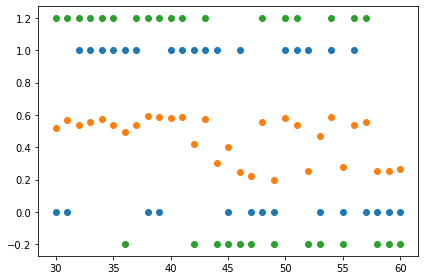

In [ ]:
plt.scatter(a[30:],y_test_list[30:],label='y_test')
plt.scatter(a[30:],y_pre_list[30:],label='?')
plt.scatter(a[30:],y_p[30:],label='??')

# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
a=[]
for i in range(len(y_test_list)):
  a.append(i)

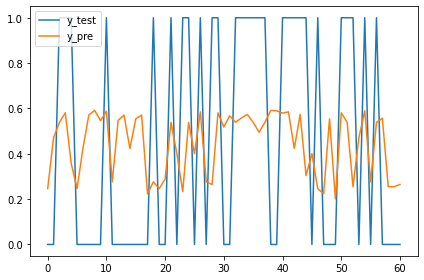

In [ ]:
plt.plot(y_test_list,label='y_test')
plt.plot(y_pre_list,label='y_pre')
# plt.plot(y_p,label='?')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
len(y_test_list[:30])

30

In [24]:
import numpy as np

In [22]:
from pygam import LogisticGAM

In [26]:
gam = LogisticGAM().fit(X_train, y_train)
gam.accuracy(X_test, y_test)

did not converge


0.7868852459016393